In [112]:
from reservoirpy.datasets import lorenz, mackey_glass
import matplotlib.pyplot as plt
import numpy as np
from reservoirpy.nodes import Reservoir
# Load data
x = mackey_glass(10000)
offset = -np.min(x, axis=0)
offset[offset < 0] = 0
x += offset
x /= np.max(x)
timeseries = x[:, 0].reshape(-1, 1)
# timeseries = x.reshape((-1, 3))
print(timeseries.shape)

(10000, 1)


*Classical*

In [113]:

res = Reservoir(20, lr=1, sr=1.0)
states = res.run(timeseries)


Running Reservoir-16:   4%|▍         | 384/10000 [00:00<00:02, 3812.62it/s]

Running Reservoir-16: 100%|██████████| 10000/10000 [00:02<00:00, 3809.04it/s]


<Figure size 640x480 with 0 Axes>

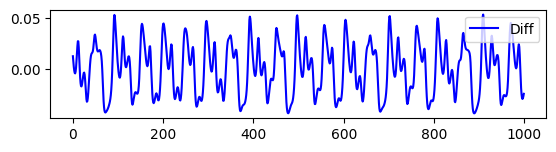

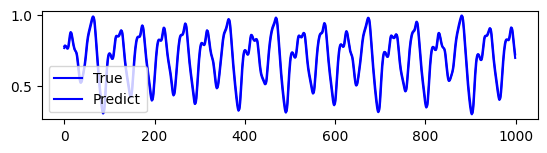

In [119]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

WARMUP = 0.1

warmup = int(len(states) * WARMUP)
x = timeseries[:-1]
target = timeseries[1:]
# target = target - np.mean(target)


x = x[warmup:]
target = target[warmup:]

# train_x, test_x, train_y, test_y = train_test_split(x, target, test_size=0.33)
M = len(x)//4
train_x = x[:M//2]
train_y = target[:M//2]

test_x = x[M//2:]
test_y = target[M//2:]
plt.figure()
# alpha_space = np.linspace(0.1, 30, 1)

# scores = np.zeros(len(alpha_space))
# for i, alpha in enumerate(alpha_space):
#     model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
#     model.fit(train_x, train_y)
#     scores[i] = model.score(test_x, test_y)

# alpha = alpha_space[np.argmax(scores)]
# print(alpha)
model = make_pipeline(StandardScaler(), Ridge(alpha=10))
model.fit(train_x, train_y)


x = x[-1000:]
target = target[-1000:]

# plt.plot(alpha_space, scores)
plt.figure()
window = len(train_x)//4
for i in range(timeseries.shape[-1]):
    plt.subplot(3, 1, i+1)
    
    plt.plot(target[:, i] - model.predict(x)[:, i], label="Diff", c='b')

    # plt.xlim([len(train_x) - window, len(train_x) + 4 * window])
    plt.legend()

plt.figure()
window = len(train_x)//4
for i in range(timeseries.shape[-1]):
    plt.subplot(3, 1, i+1)
    
    plt.plot(target[:, i], label="True", c='b')
    plt.plot(model.predict(x)[:, i], label="Predict", c='b')

    # plt.xlim([len(train_x) - window, len(train_x) + 4 * window])
    plt.legend()
# plt.plot(test_y , label="True")
# plt.plot(model.predict(test_x), label="test")

plt.legend()
plt.show()